# Doğal Dil İşleme (NLP)

# 1.Metin Ön İşleme (Text Pre-processing)

In [2]:
!pip install nltk

In [4]:
!pip install textblob

In [5]:
!pip install wordcloud

In [6]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [7]:
df = pd.read_csv("datasets/amazon_reviews.csv", sep=",") # Amazonda bir ürüne yapılan yorumları içeren data
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.00,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.00,best deal around,1373673600,2013-07-13,513,0,0


In [8]:
df.reviewText # Odaklanacağımız kısım burası. Ürüne yapılan yorumlar

0                                              No issues.
1       Purchased this for my device, it worked as adv...
2       it works as expected. I should have sprung for...
3       This think has worked out great.Had a diff. br...
4       Bought it with Retail Packaging, arrived legit...
                              ...                        
4910    I bought this Sandisk 16GB Class 10 to use wit...
4911    Used this for extending the capabilities of my...
4912    Great card that is very fast and reliable. It ...
4913    Good amount of space for the stuff I want to d...
4914    I've heard bad things about this 64gb Micro SD...
Name: reviewText, Length: 4915, dtype: object

* Normalizing Case Folding (Metin Önişleme)

Birinci aşama olarak tüm metinleri standart bir formata dönüştürmek istiyoruz. Bu yüzden hepsine küçük harf dönüşümü yapıyoruz.

In [9]:
# Büyük küçük harf kargaşını ortadan kaldırıp standart bile hale sokmak için dönüşüm yapıyoruz.

df["reviewText"] = df["reviewText"].str.lower() # Tüm harfleri küçük yaptık.
df.reviewText

0                                              no issues.
1       purchased this for my device, it worked as adv...
2       it works as expected. i should have sprung for...
3       this think has worked out great.had a diff. br...
4       bought it with retail packaging, arrived legit...
                              ...                        
4910    i bought this sandisk 16gb class 10 to use wit...
4911    used this for extending the capabilities of my...
4912    great card that is very fast and reliable. it ...
4913    good amount of space for the stuff i want to d...
4914    i've heard bad things about this 64gb micro sd...
Name: reviewText, Length: 4915, dtype: object

* Punctuations

Küçük harf dönüşümünden sonra bir anlam ifade etmeyen noktalama işaretlerinden kurtuluyoruz.

In [10]:
# Noktalama işaretlerini de kaldırarak daha optimum bir metin elde edebiliriz.

df["reviewText"] = df["reviewText"].str.replace("[^\w\s]", "") # RegEx kalıbı ile noktalama işaretlerini boşluk ile değiştiriyoruz.
df.reviewText

0                                               no issues
1       purchased this for my device it worked as adve...
2       it works as expected i should have sprung for ...
3       this think has worked out greathad a diff bran...
4       bought it with retail packaging arrived legit ...
                              ...                        
4910    i bought this sandisk 16gb class 10 to use wit...
4911    used this for extending the capabilities of my...
4912    great card that is very fast and reliable it c...
4913    good amount of space for the stuff i want to d...
4914    ive heard bad things about this 64gb micro sd ...
Name: reviewText, Length: 4915, dtype: object

* Numbers

Çalıştığımız senaryo gereği rakamlar bir anlam ifade etmeyeceği için rakamlardan kurtuluyoruz.

In [11]:
# Bu çalışmamızda rakamlardan kurtulmak istiyoruz.

df["reviewText"] = df["reviewText"].str.replace("\d", "") # Rakamları boşluk ile değiştir.
df.reviewText

0                                               no issues
1       purchased this for my device it worked as adve...
2       it works as expected i should have sprung for ...
3       this think has worked out greathad a diff bran...
4       bought it with retail packaging arrived legit ...
                              ...                        
4910    i bought this sandisk gb class  to use with my...
4911    used this for extending the capabilities of my...
4912    great card that is very fast and reliable it c...
4913    good amount of space for the stuff i want to d...
4914    ive heard bad things about this gb micro sd ca...
Name: reviewText, Length: 4915, dtype: object

*stopwords: Bir anlam ifade etmeyen ve dilde kullanılan yaygın kelimelerdir.
Bu kelimeler model için bir anlam ifade etmeyeceği için kurtuluyoruz.

In [12]:
import nltk
#nltk.download("stopwords")

sw = stopwords.words("english") # İngilizce stopwords'leri kaydettik.

In [13]:
# Datamızdan bu tuttuğumuz stopwords'leri temizlemek istiyoruz.

# Her row için cümleleri boşluk karakterine göre ayır. "sw" içerisinde olmayan her bir elemanı tekrar birleştir.
df["reviewText"] = df["reviewText"].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
df.reviewText

0                                                  issues
1       purchased device worked advertised never much ...
2       works expected sprung higher capacity think ma...
3       think worked greathad diff bran gb card went s...
4       bought retail packaging arrived legit orange e...
                              ...                        
4910    bought sandisk gb class use htc inspire months...
4911    used extending capabilities samsung galaxy not...
4912    great card fast reliable comes optional adapte...
4913          good amount space stuff want fits gopro say
4914    ive heard bad things gb micro sd card crapping...
Name: reviewText, Length: 4915, dtype: object

* Rarewords: Metinlerde nadiren geçen kelimelerdir.
Modelleme aşamasında nadiren geçen kelimelerden bir örüntü yakalayamayız. Bu yüzden bu kelimelerden kurtulmak istiyoruz

In [14]:
temp_df = pd.Series(" ".join(df["reviewText"]).split()).value_counts() # Bir thresholda göre ayıklama yapacağımız için tüm kelimeleri saydırıyoruz.
temp_df

card          4603
gb            1725
phone         1685
works         1559
great         1445
              ... 
sharper          1
cheapos          1
gate             1
measuring        1
stealwould       1
Length: 9701, dtype: int64

In [15]:
drops = temp_df[temp_df <2] # Tüm metin içerisinde 1 defa geçen kelimeler
df["reviewText"] = df["reviewText"].apply(lambda x: " ".join(x for x in x.split() if x not in drops)) # 1 defa geçen kelimeler dışındakileri tut.
df.reviewText

0                                                  issues
1       purchased device worked advertised never much ...
2       works expected higher capacity think made bit ...
3       think worked gb card went south one held prett...
4       bought retail packaging arrived legit envelope...
                              ...                        
4910    bought sandisk gb class use htc inspire months...
4911    used capabilities samsung galaxy note greatly ...
4912    great card fast reliable comes optional adapte...
4913          good amount space stuff want fits gopro say
4914    ive heard bad things gb micro sd card crapping...
Name: reviewText, Length: 4915, dtype: object

* Tokenization: Cümleleri parçalarına (tokenlerine) ayırmaktır.


In [16]:
# nltk.download("punkt")

df["reviewText"].apply(lambda x: TextBlob(x).words).head() # Tüm kelimeler tokenlara ayrıldı.

0                                             [issues]
1    [purchased, device, worked, advertised, never,...
2    [works, expected, higher, capacity, think, mad...
3    [think, worked, gb, card, went, south, one, he...
4    [bought, retail, packaging, arrived, legit, en...
Name: reviewText, dtype: object

In [17]:
# nltk.download("wordnet")

df["reviewText"] = df["reviewText"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df.reviewText

0                                                   issue
1       purchased device worked advertised never much ...
2       work expected higher capacity think made bit e...
3       think worked gb card went south one held prett...
4       bought retail packaging arrived legit envelope...
                              ...                        
4910    bought sandisk gb class use htc inspire month ...
4911    used capability samsung galaxy note greatly ex...
4912    great card fast reliable come optional adapter...
4913           good amount space stuff want fit gopro say
4914    ive heard bad thing gb micro sd card crapping ...
Name: reviewText, Length: 4915, dtype: object

# 2. Metin Görselleştirme (Text Visualization)

Terim Frekanslarının Hesaplanması

In [18]:
# Satır bazında ilgili kelimelerin frekanslarını çıkartıyoruz.
tf = df["reviewText"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf.columns = ["words", "tf"]
tf.head()

,words,tf
0,issue,609.00
1,purchased,344.00
2,device,584.00
3,worked,460.00
4,advertised,111.00


In [19]:
# En fazla geçen kelimeler hangileri?

tf.sort_values("tf", ascending=False).head(10)

,words,tf
27,card,5537.00
14,work,2044.00
7,phone,1909.00
39,gb,1756.00
98,great,1445.00
8,memory,1378.00
71,sandisk,1286.00
63,sd,1209.00
36,one,1120.00
198,use,1115.00


Barplot

In [20]:
# Okunabilir bir Bar Plot için bir filtreleme yapmalıyız.

tf[tf["tf"] > 500].head(10) # 500'den fazla geçen kelimeler

,words,tf
0,issue,609.00
2,device,584.00
7,phone,1909.00
8,memory,1378.00
14,work,2044.00
26,note,514.00
27,card,5537.00
33,well,677.00
36,one,1120.00
39,gb,1756.00


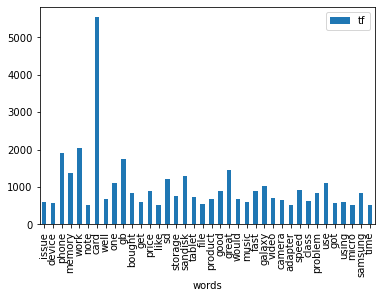

In [21]:
# En fazla geçen kelimenin "card" olduğu açıkca gözüküyor. 
# Genel tabloyu incelediğimizde bu ürünün bir telefon ya da karta ait olduğu sonucuna varabiliriz.

tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
plt.show()

* Wordcloud 

İlgili metindeki kelimelerin geçme frekanslarına göre bir bulut şeklinde görsel oluşturulması işi

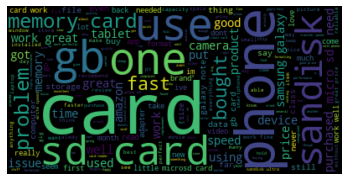

In [22]:
# Tüm datayı tek bir text haline dönüştürdük.
text = " ".join(i for i in df.reviewText)

wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear") # Frekanslara göre kelime boyutları artıyor.
plt.axis("off")
plt.show()

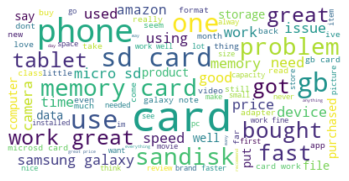

In [23]:
# Belirlediğimiz font_size ile belirli miktardaki kelimeyi görselleştirmek istersek

wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

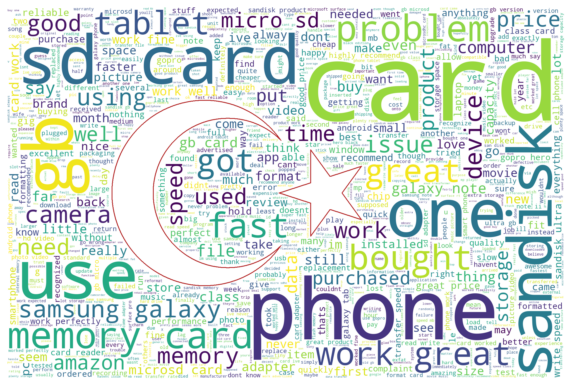

In [24]:
# Bir şablona göre Word Cloud oluşturmak istersek

tr_mask = np.array(Image.open("tr.png"))

wc = WordCloud(background_color="white",
               max_words=1000,
               mask=tr_mask,
               contour_width=3,
               contour_color="firebrick")

wc.generate(text)
plt.figure(figsize=[10, 10])
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

# 3. Duygu Durum Analizi (Sentiment Analysis)

Metinlerin duygu durumunu matematiksel olarak ifade etmektir.

In [25]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ceyda\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [26]:
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("The film was awesome")
#bu cümlenin skoruna bakalım.
# compound skoruna odaklanacağız. Eğer bu skor >0 ise ilgili cümle pozitiftir.

{'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'compound': 0.6249}

In [27]:
sia.polarity_scores("I liked this music but it is not good as the other one")
# compount değerine göre bu cümle olumsuz anlam taşıyor.

{'neg': 0.207, 'neu': 0.666, 'pos': 0.127, 'compound': -0.298}

In [29]:
# Bu skorlama işlemini "reviewText" üzerinde her bir değere uygulayalım.
df["polarity_score"] = df["reviewText"].apply(lambda x: sia.polarity_scores(x)["compound"])
df.polarity_score.head()

0   0.00
1   0.00
2   0.40
3   0.65
4   0.86
Name: polarity_score, dtype: float64

# 4. Feature Engineering

In [30]:
# polarity_scores üzerinde 0 dan küçük olan değerlere neg, büyük olan değerlere pos diyelim.

df["reviewText"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

0    neg
1    neg
2    pos
3    pos
4    pos
5    neg
6    pos
7    pos
8    neg
9    pos
Name: reviewText, dtype: object

In [31]:
# Supervised Learning mantığı ile bir modelleme yapmak isteyelim.
# Bu yüzden daha önce elde ettiğimiz skorlar üzerinden bir label kolonu oluşturuyoruz.

df["sentiment_label"] = df["reviewText"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

df["sentiment_label"].value_counts()

pos    3944
neg     971
Name: sentiment_label, dtype: int64

In [32]:
# Oluşturduğumuz "label" kırılımında verilen puanların ortalamasına bakalım.

df.groupby("sentiment_label")["overall"].mean()

sentiment_label
neg   4.09
pos   4.71
Name: overall, dtype: float64

In [33]:
# Target değişkenimizi LabelEncoder'dan geçiriyoruz.
df["sentiment_label"] = LabelEncoder().fit_transform(df["sentiment_label"])

y = df["sentiment_label"] # Bağımlı Değişkenimiz
X = df["reviewText"] # Bağımsız Değişkenimiz

* NOT: Bağımsız değişkenimiz (reviewText) şu an text olarak tutuluyor. Bir Machine Learning modeli oluşturmak için buna müdahale etmeliyiz.

## Count Vectors

* Text üzerinden sayısal değişkenler oluşturarak modellenebilir hale getirme işlemlerini yapacağız.
* Bunu yapmanın birinci yolu "Count Vectors" yöntemidir. Bu yöntem metinleri frekans kullanarak temsil eder.
       Words: Kelimelerin nümerik temsilleri
       Characters: Karakterlerin nümerik temsilleri
       ngram: Birlikte kullanılan kelimelerin kombinasyolarını gösterir.

In [34]:
#ngram

a = """Bu örneği anlaşılabilmesi için daha uzun bir metin üzerinden göstereceğim.
N-gram'lar birlikte kullanılan kelimelerin kombinasyolarını gösterir ve feature üretmek için kullanılır"""

TextBlob(a).ngrams(3) # Metnin 3lü kombinasyonlarını çıkartır.

[WordList(['Bu', 'örneği', 'anlaşılabilmesi']),
 WordList(['örneği', 'anlaşılabilmesi', 'için']),
 WordList(['anlaşılabilmesi', 'için', 'daha']),
 WordList(['için', 'daha', 'uzun']),
 WordList(['daha', 'uzun', 'bir']),
 WordList(['uzun', 'bir', 'metin']),
 WordList(['bir', 'metin', 'üzerinden']),
 WordList(['metin', 'üzerinden', 'göstereceğim']),
 WordList(['üzerinden', 'göstereceğim', "N-gram'lar"]),
 WordList(['göstereceğim', "N-gram'lar", 'birlikte']),
 WordList(["N-gram'lar", 'birlikte', 'kullanılan']),
 WordList(['birlikte', 'kullanılan', 'kelimelerin']),
 WordList(['kullanılan', 'kelimelerin', 'kombinasyolarını']),
 WordList(['kelimelerin', 'kombinasyolarını', 'gösterir']),
 WordList(['kombinasyolarını', 'gösterir', 've']),
 WordList(['gösterir', 've', 'feature']),
 WordList(['ve', 'feature', 'üretmek']),
 WordList(['feature', 'üretmek', 'için']),
 WordList(['üretmek', 'için', 'kullanılır'])]

In [35]:
# Count Vectors kullanarak word, character ve ngram tipinden denemeler yapacağız.

from sklearn.feature_extraction.text import CountVectorizer

corpus = ['This is the first document.',
          'This document is the second document.',
          'And this is the third one.',
          'Is this the first document?']

In [37]:
# word frekans
vectorizer = CountVectorizer()
X_c = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names() # Tüm metinlerde geçen eşsiz kelimelerin listesini çıkartıyor.
print(vectorizer.get_feature_names())
X_c.toarray()  # Her bir review için kelimelerin frekanslarını tutuyor.

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']


array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 2, 0, 1, 0, 1, 1, 0, 1],
       [1, 0, 0, 1, 1, 0, 1, 1, 1],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]], dtype=int64)

In [38]:
# n-gram frekans
vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2, 2))  # (2,2) yani 2li kelime öbekleri istiyoruz.
X_n = vectorizer2.fit_transform(corpus)
vectorizer2.get_feature_names()
print(vectorizer2.get_feature_names()) # 2li kelime öbeklerini çıkartır.
X_n.toarray()  # 2li kelime öbeklerinin içerip içermemesine göre çıktı döndürür.

['and this', 'document is', 'first document', 'is the', 'is this', 'second document', 'the first', 'the second', 'the third', 'third one', 'this document', 'this is', 'this the']


array([[0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
       [0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1]], dtype=int64)

In [39]:
# Yukarıda anlatılan yöntemlerden birini kullanarak artık kendi verimizde modelleme aşamasına geçebiliriz.

# word frekans kullanıyorum.
vectorizer = CountVectorizer()
X_count = vectorizer.fit_transform(X)

print(vectorizer.get_feature_names()[10:15]) # Bazı kelimelere bakalım
X_count.toarray()[10:15]

['access', 'accessed', 'accessible', 'accessing', 'accessory']


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

## TF-IDF 

* Count Vector yönteminin ortaya çıkarabileceği bazı yanlılıkları gidermek adına standartlaştırılmış bir kelime vektörü oluşturma yöntemidir.
* Kelimelerin dökümanlarda geçme frekansını ve kelimelerin bütün metinde geçme frekanslarını kullanarak bir standartlaştırma yapar.

* ADIM 1:

Count Vectorizer'ı Hesapla (Kelimelerin her bir dokümandaki frekansı)
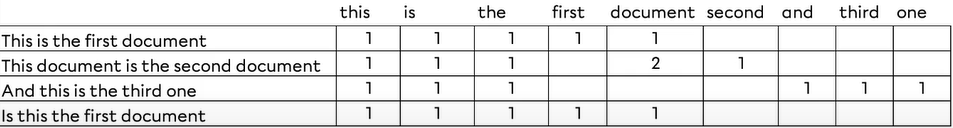

* ADIM 2:

TF - Term Frequency'yi Hesapla (t teriminin ilgili dökümandaki frekansı / dokümandaki toplam terim sayısı)
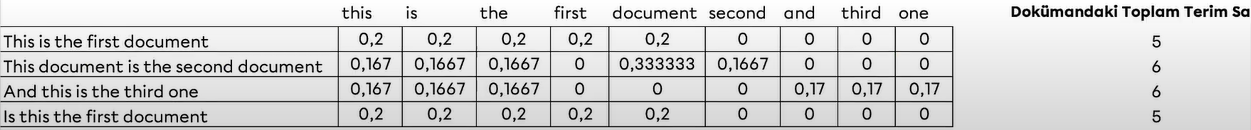

* ADIM 3:

IDF - Inverse Document Frequency'i Hesapla
1 + loge((toplam döküman sayısı +1) / (içinde t terimi olan döküman sayısı + 1))

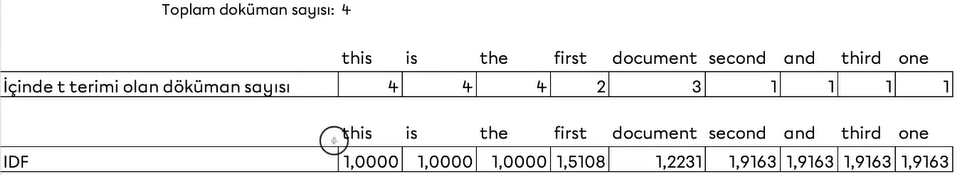

* ADIM 4:

TF * IDF'i Hesapla
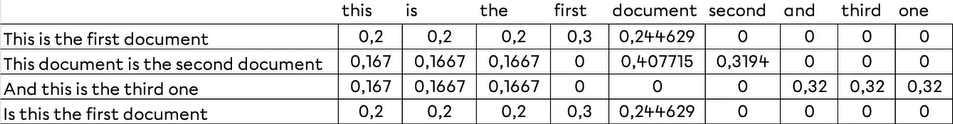

* ADIM 5:

L2 Normalizasyonu Yap
Satırların kareleri toplamının karekökünü bul, ilgili satırdaki tüm hücreleri bulduğun değere böl.

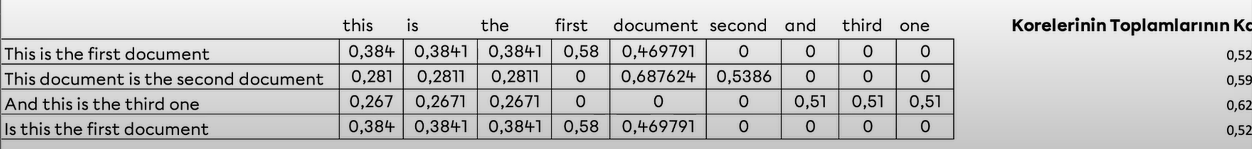

In [40]:
# TF-IDF

# word frekans
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_word_vectorizer = TfidfVectorizer()
X_tf_idf_word = tf_idf_word_vectorizer.fit_transform(X) # TF-IDF yöntemi ile word frekans

In [41]:
# ngram frekans

tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2, 3))
X_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(X) # TF-IDF yöntemi ile ngram frekans

# 5.Sentiment Modeling

## Logistic Regression

In [42]:
log_model = LogisticRegression().fit(X_tf_idf_word, y)

cross_val_score(log_model,
                X_tf_idf_word,
                y,
                scoring="accuracy",
                cv=5).mean()
# Modelleme sonucunda ürüne gelen yorumun olumlu veya olumsuz olduğunu %83 doğru tahminliyoruz

0.830111902339776

In [43]:
# Böyle bir yorum gelmiş olsun
new_review = pd.Series("this product is great") 

# Gelen ham yorumu daha önce yaptığımız işlemlerden geçirmeyi unutmamalıyız!
new_review = TfidfVectorizer().fit(X).transform(new_review)

log_model.predict(new_review)
# Modelimiz gelen yorum için "1" çıktısı verdi.

array([1])

In [44]:
# Başka bir yorum daha gelsin
new_review = pd.Series("look at that shit very bad")

# Gelen ham yorumu daha önce yaptığımız işlemlerden geçirmeyi unutmamalıyız!
new_review = TfidfVectorizer().fit(X).transform(new_review)

log_model.predict(new_review)
# Modelimiz gelen yorum için "0" çıktısı verdi.

array([0])

In [45]:
# Başka bir yorum daha gelsin
new_review = pd.Series("it was good but I am sure that it fits me")

# Gelen ham yorumu daha önce yaptığımız işlemlerden geçirmeyi unutmamalıyız!
new_review = TfidfVectorizer().fit(X).transform(new_review)

log_model.predict(new_review)
# Modelimiz gelen yorum için "1" çıktısı verdi.

array([1])

In [51]:
# Şimdi kendi orjinal veri setimiz için yorum çekip yorumları modele sorup sonuca bakacak olursak:

# reviewText üxerinden bir örnek çekiyorum ve bu örnek neticesindeki string değerin kendisine erişmek istiyorum.
random_review = pd.Series(df["reviewText"].sample(1).values)
print(random_review)

new_review = TfidfVectorizer().fit(X).transform(random_review)

log_model.predict(new_review)

0    buy product add cheap sd card shame go class s...
dtype: object


array([1])

## Random Forests 

In [52]:
# Count Vectors
rf_model = RandomForestClassifier().fit(X_count, y) # X_count değişkenini Count Vectors bölümünde elde etmiştik.
cross_val_score(rf_model, X_count, y, cv=5, n_jobs=-1).mean()

0.8413021363173957

In [53]:
# TF-IDF Word-Level
rf_model = RandomForestClassifier().fit(X_tf_idf_word, y)
cross_val_score(rf_model, X_tf_idf_word, y, cv=5, n_jobs=-1).mean()

0.8272634791454729

In [54]:
# TF-IDF N-GRAM
rf_model = RandomForestClassifier().fit(X_tf_idf_ngram, y)
cross_val_score(rf_model, X_tf_idf_ngram, y, cv=5, n_jobs=-1).mean()


0.7867751780264497

## Hiperparametre Optimizasyonu

In [55]:
rf_model = RandomForestClassifier(random_state=17)

rf_params = {"max_depth": [8, None],
             "max_features": [7, "auto"],
             "min_samples_split": [2, 5, 8],
             "n_estimators": [100, 200]}

rf_best_grid = GridSearchCV(rf_model,
                            rf_params,
                            cv=5,
                            n_jobs=-1,
                            verbose=1).fit(X_count, y)

rf_best_grid.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


{'max_depth': None,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 100}

In [56]:
# En düşük hatayı verdiğini bildiğim (başarı olasılığı en yüksek olan) X_count yöntemine göre modelimi tekrar fit ediyorum.

rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X_count, y)


cross_val_score(rf_final, X_count, y, cv=5, n_jobs=-1).mean()

0.8408952187182095

* Amacımız bir model ile gelen bir yorumun pozitif ya da negatif olup olmadığını öğrenmekti.
* Çeşitli yöntemler ve modeller ile farklı başarılar elde ettik.